In [46]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # Import the matplotlib.pyplot module

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the neural network architecture
class MultiplierModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, pretrained_model=None):
        super(MultiplierModel, self).__init__()

        # Calculate the number of hidden layers based on the provided hidden_size
        num_hidden_layers = max(0, int(math.log2(hidden_size)) - 4)  # Subtract 2

        self.num_hidden_layers = num_hidden_layers  # Add this line to set the attribute

        # Dynamically create Linear layers and assign them to attributes
        for layer in range(num_hidden_layers + 1):
            in_features = hidden_size // (2 ** layer) if layer > 0 else input_size
            out_features = hidden_size // (2 ** (layer + 1)) if layer < num_hidden_layers else output_size
            setattr(self, f'fc{layer+1}', nn.Linear(in_features, out_features))

        self.relu = nn.ReLU()

        if pretrained_model is not None:
            for layer in range(num_hidden_layers + 1):
                source_weight = getattr(pretrained_model, f'fc{layer+1}.weight', None)
                source_bias = getattr(pretrained_model, f'fc{layer+1}.bias', None)
                target_weight = getattr(self, f'fc{layer+1}.weight', None)
                target_bias = getattr(self, f'fc{layer+1}.bias', None)
                if source_weight is not None and target_weight is not None:
                    target_weight.data.copy_(torch.randn_like(source_weight))
                if source_bias is not None and target_bias is not None:
                    target_bias.data.copy_(torch.randn_like(source_bias))

    def forward(self, x):
        for layer in range(1, self.num_hidden_layers + 1):
            x = self.relu(getattr(self, f'fc{layer}')(x))
        return getattr(self, f'fc{self.num_hidden_layers + 1}')(x) 

# Generate random sample data
np.random.seed(42)
num_samples = 100000
test_array = [0.236, 0.382, 0.5, 0.618, 0.786, 1, 1.236, 1.382, 1.618, 2, 2.618, 3, 3.618, 4.236]
random_columns = np.random.rand(num_samples, 2).astype(np.float32)
constant_columns = np.tile(np.array(test_array).astype(np.float32), (num_samples, 1))

X = np.concatenate((random_columns, constant_columns), axis=1)

# Compute y as the product of the first two columns
y = (X[:, 0] * X[:, 1]).reshape(-1, 1).astype(np.float32)

# Extend y to include the constant values for each row
constant_values = np.tile(np.array(test_array, dtype=np.float32), (num_samples, 1))
y = np.concatenate((y, constant_values), axis=1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)

# Convert data to PyTorch tensors and move to GPU if available
X_train_tensor = torch.tensor(X_train, device=device)
y_train_tensor = torch.tensor(y_train, device=device)
X_val_tensor = torch.tensor(X_val, device=device)
y_val_tensor = torch.tensor(y_val, device=device)


# Create an instance of the model and move it to GPU if available
model = MultiplierModel(2 + len(test_array), 512, 1 + len(test_array)).to(device)
#model = MultiplierModel2().to(device)

save_load = True
if save_load:
    # Attempt to load the model parameters from a file
    try:
        model.load_state_dict(torch.load("model_multiplier3.pth"))
        print("Model loaded successfully.")
    except FileNotFoundError:
        print("Model file not found. Creating a new model.")

print('model', model)
#criterion = nn.L1Loss()
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

criterion = nn.MSELoss()  # Use Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.0001)

model.train()
# Training loop
num_epochs = 1000
print_interval = 250
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % print_interval == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "f"Train Loss: {loss.item():.4f}")

# Calculate validation loss
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    val_loss = criterion(val_outputs, y_val_tensor)

print(f"Epoch [{epoch+1}/{num_epochs}], "f"Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

print("Training finished!")

if save_load:
    # Save the trained model
    torch.save(model.state_dict(), 'model_multiplier3.pth')



Using device: cuda
Model loaded successfully.
model MultiplierModel(
  (fc1): Linear(in_features=16, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=16, bias=True)
  (fc6): Linear(in_features=16, out_features=15, bias=True)
  (relu): ReLU()
)
Epoch [250/1000], Train Loss: 0.0001
Epoch [500/1000], Train Loss: 0.0001
Epoch [750/1000], Train Loss: 0.0001
Epoch [1000/1000], Train Loss: 0.0001
Epoch [1000/1000], Train Loss: 0.0001, Val Loss: 0.0001
Training finished!


predicted_y [[0.1189893  0.23556112 0.3803157  0.5011046  0.6161907  0.7887452
  1.0018771  1.237829   1.3829043  1.6191355  2.0008943  2.6160848
  3.0020695  3.6195107  4.2376766 ]
 [0.21861584 0.2356988  0.37985775 0.5008965  0.61584395 0.7886222
  1.0021762  1.2379787  1.382903   1.6197864  2.000076   2.6160061
  3.0008729  3.6190884  4.237607  ]
 [0.6880296  0.23542188 0.38080376 0.5015384  0.6169391  0.7886533
  1.0014248  1.2373902  1.3832866  1.6188238  2.0019343  2.6161408
  3.0029864  3.6198497  4.237187  ]]
X_test [[0.11836167 0.7286343  0.236      0.382      0.5        0.618
  0.786      1.         1.236      1.382      1.618      2.
  2.618      3.         3.618      4.236     ]
 [0.66947716 0.41989857 0.236      0.382      0.5        0.618
  0.786      1.         1.236      1.382      1.618      2.
  2.618      3.         3.618      4.236     ]
 [0.7714704  0.9036288  0.236      0.382      0.5        0.618
  0.786      1.         1.236      1.382      1.618      2.
  2.618

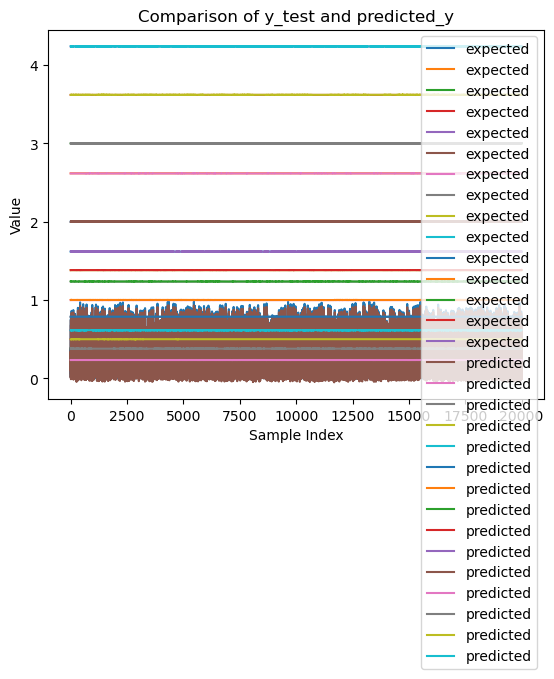

' plt.figure(figsize=(8, 6))\nplt.scatter(range(len(X_test)), y_test[0], label=\'Expected\', marker=\'o\')\nplt.scatter(range(len(X_test)), predicted_y[0], label=\'Predicted\', marker=\'x\')\nplt.xlabel("Time (Epochs)")\nplt.ylabel("Value")\nplt.title("Expected vs. Predicted Results over Time")\nplt.grid(True)\nplt.legend()\nplt.show() '

In [48]:


# Generate a new test dataset
#X_test = np.random.rand(100, 3).astype(np.float32)
#y_test = X_test.prod(axis=1)

X_test = X_val
y_test = y_val

# Convert the test data to PyTorch tensors and move to GPU if available
X_test_tensor = torch.tensor(X_test, device=device)

# Run predictions using the trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predicted_y = model(X_test_tensor)

# Move predictions and ground truth back to CPU for plotting
predicted_y = predicted_y.cpu().numpy()

# Print expected and predicted results along with their corresponding multipliers
#for i in range(len(X_test) - 5, len(X_test)):
#   print('predicted_y',predicted_y[i])
    #print('X_test', X_test[i])
    #multiplier1, multiplier2, const1, const2, const3 = X_test[i]
#    expected_result = y_test[i]
#    predicted_result = predicted_y[i]
#    print('expected_result', expected_result)
#    print('predicted_result', predicted_result) """
#        print(f"{float(const1):.4f} : {float(const2):.4f} : {float(const3):.4f} = "
#         f"{float(expected_result):.4f} => Predicted Result: {float(predicted_result):.4f}")

print('predicted_y',predicted_y[-3:])
print('X_test', X_test[-3:])

plt.figure()
plt.plot(y_test, label='expected')
plt.plot(predicted_y, label='predicted')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of y_test and predicted_y')
plt.show()


# Create a plot with time (epochs) on the x-axis and both expected and predicted values as individual balls
""" plt.figure(figsize=(8, 6))
plt.scatter(range(len(X_test)), y_test[0], label='Expected', marker='o')
plt.scatter(range(len(X_test)), predicted_y[0], label='Predicted', marker='x')
plt.xlabel("Time (Epochs)")
plt.ylabel("Value")
plt.title("Expected vs. Predicted Results over Time")
plt.grid(True)
plt.legend()
plt.show() """